In [1]:
import sklearn
import numpy as np

%matplotlib inline 
import matplotlib.pyplot as plt

### PCA (Principal Component Analysis)

By far the most popular dimensionality reduction algorithm. Identifies the hyperplane closest to all of the data then projects data onto that hyperplane.

The hyperplane selected will try to preserve the variance of the original dataset. Another way to see this is PCA aims to minimize the MSE between the projected data and the original dataset.

Principal components are found via *Singular Value Decomposition*. **PCA assumes that data is centered aorund origin, so make sure to subtract the mean from the data before running PCA.**

In [2]:
from sklearn.datasets import make_swiss_roll

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

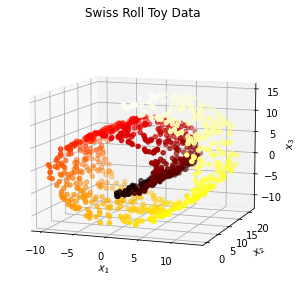

In [3]:
def plot_data(X):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(10, -70)
    ax.set_xlabel(r"$x_1$")
    ax.set_ylabel(r"$x_2$")
    ax.set_zlabel(r"$x_3$")
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
    return ax

plot_data(X)
plt.title("Swiss Roll Toy Data")
plt.show()

In [4]:
U, s, Vt = np.linalg.svd(X)
print("Principal Components = \n", Vt) # num principal components always equals the num features

Principal Components = 
 [[-0.20828585 -0.97712622 -0.04291113]
 [ 0.52027642 -0.1478406   0.8411038 ]
 [-0.82820858  0.15286437  0.53916884]]


### Projecting Down to *d* Dimensions

Simply compute $X_{d_{proj}} = XW_{d_{proj}}$

In [5]:
# for d = 2
W_2d = Vt[:, :2]
X_2d = X.dot(W_2d)

### Using Scikit-Learn

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
X_2d = pca.fit_transform(X)

print("Principal Components = \n", pca.components_) # PCs stored as horizontal vectors

Principal Components = 
 [[ 0.56791312  0.15670748  0.80803308]
 [-0.77712377 -0.2213858   0.5891239 ]
 [ 0.27120717 -0.96251291 -0.00394679]]


### Explained Variance Ratio

Tells how much variance of the data lies on each Principal Component axis.

In [7]:
print(f"Explained variance ratio = {pca.explained_variance_}")

Explained variance ratio = [52.52397747 38.89506814 37.37176222]


### Choosing the Right Number of Dimensions

Generally preferable to choose number of dimensions that add up to ~95% of variance across principal components.

In [8]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [9]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [10]:
pca = PCA()
pca.fit(X_train)

cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95)
print(f"feature dim of data = {X_train.shape[1]}")
print(f"95% variance dimension d = {d}")

feature dim of data = 784
95% variance dimension d = 153


In [11]:
# another way to specify the ratio of variance to preserve
pca = PCA(n_components=0.95)
X_reduced = pca.fit(X_train)

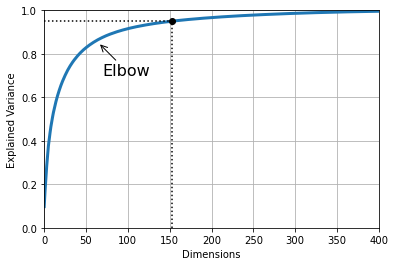

In [12]:
# plot the explained variance ratio and look for elbow
# this is the "intrinsic dimensionality" of the dataset
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.show()

To apply the inverse of PCA, use the equation $X_{recovered} = X_{d_{proj}}W_d^T$. Some of the original data will be loss of course since PCA only kept ~95% of the variance.

### Randomized PCA

`sklearn` can use a stochastic algo (*Randomized PCA*) to find an approximation of the first *d* principal components. Dramatically faster than full PCA when $d < n$.

In [13]:
import time

pca = PCA(svd_solver="full")
rnd_pca = PCA(n_components=d, svd_solver="randomized")

start = time.time()
pca.fit(X_train)
end = time.time()
print(f"PCA fit time = {end - start:.4f}")

start = time.time()
rnd_pca.fit(X_train)
end = time.time()
print(f"Random PCA fit time = {end - start:.4f}")

PCA fit time = 7.4044
Random PCA fit time = 4.1682


### Incremental PCA

Alleviates the issue since normal PCA requires full dataset to be in memory to run SVD. IPCA was developed which takes in mini-batches of the training data and does partial fits.

In [16]:
from sklearn.decomposition import IncrementalPCA

run_incremental = False

if run_incremental:
    inc_pca = IncrementalPCA(n_components=d)
    n_batches = 100

    for X_batch in np.array_split(X_train, n_batches):
        inc_pca.partial_fit(X_batch)

    X_reduced = inc_pca.transform(X_train)

### Kernel PCA

kPCA an utilize kernel trick from SVMs to PCA as well. This makes it possible to perform complex nonlinear projections for dimensionality reduction.

Often good at preserving clusters of instances after projection.

In [17]:
from sklearn.decomposition import KernelPCA

run_kernel = False

if run_kernel:
    lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True) # equivalent to using the normal PCA class
    rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
    sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

    y = t > 6.9

    plt.figure(figsize=(11, 4))
    for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
        X_reduced = pca.fit_transform(X)
        if subplot == 132:
            X_reduced_rbf = X_reduced
        
        plt.subplot(subplot)
        plt.title(title, fontsize=14)
        plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
        plt.xlabel("$z_1$", fontsize=18)
        if subplot == 131:
            plt.ylabel("$z_2$", fontsize=18, rotation=0)
        plt.grid(True)

    plt.show()

### LLE (Locally Linear Embedding)

LLE does not rely on projections but rather: 1. measure how each training instance linearly relates to its closest neighbors; 2. look for low-dimensional representation of the training set where local relationships are best preserved.

LLEs are particularly good at unrolling twisted manifolds, esp. when there's not too much noise.

NOTE: takes too long to run a lot of code so no cell outputs.

In [1]:
from sklearn.manifold import LocallyLinearEmbedding

train_lle = False

if train_lle:
    lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10)
    X_reduced = lle.fit_transform(X)